In [ ]:
import os

!pip install git+https://github.com/igraugar/shap.git
import shap
shap.initjs()

import numpy as np
np.random.seed(1)
import numpy.linalg as la
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelBinarizer
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import random
random.seed(1)

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Sigmoid transfer function"""
def sigmoid(A, l=1, h=0):
    return 1.0 / (1.0 + np.exp(-l*(A-h)))

"""Hyperbolic transfer function"""
def hyperbolic(A):
    return np.tanh(A)

"""Rescaled transfer function"""
def rescaled(A):
    if la.norm(A)==0.0:
        return np.zeros(A.shape)
    else:
        return A / la.norm(A)

"""Recurrent reasoning process"""
def reasoning(W, A, T=50, phi=0.8, function=rescaled):
    
    states = np.zeros([len(A), T, len(W)])
    states[:,0,:] = A
    
    for t in range(1,T):
        A = states[:,t,:] = (phi * function(np.matmul(A, W)) + (1-phi) * states[:,0,:])

    return states, A

In [3]:
file = 'credit_correlation_matrix.csv'

df = abs(pd.read_csv(file))
W0 = df.to_numpy().reshape(len(df.columns), len(df.columns))

names = df.columns.tolist()

In [4]:
df = pd.read_csv("german credit dataset.csv")

y = df.values[:, -1].astype(int)

df = df.iloc[:,:-1]
original_features = df.columns

def encode_and_transform(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res

for column, dtype in df.dtypes.to_dict().items():
    if dtype == 'object':
        df = encode_and_transform(df, column)

X = df.values
df.head()

,F2,F5,F8,F11,F16,F18,F1_A11,F1_A12,F1_A13,F1_A14,...,F15_A152,F15_A153,F17_A171,F17_A172,F17_A173,F17_A174,F19_A191,F19_A192,F20_A201,F20_A202
0,0.029412,0.050567,1.000000,1.000000,0.333333,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
1,0.647059,0.313690,0.333333,0.333333,0.000000,0,0,1,0,0,...,1,0,0,0,1,0,1,0,1,0
2,0.117647,0.101574,0.333333,0.666667,0.000000,1,0,0,0,1,...,1,0,0,1,0,0,1,0,1,0
3,0.558824,0.419941,0.333333,1.000000,0.000000,1,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0
4,0.294118,0.254209,0.666667,1.000000,0.333333,1,1,0,0,0,...,0,1,0,0,1,0,1,0,1,0


In [5]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
model = RandomForestClassifier(random_state=0).fit(X_train, Y_train)

In [6]:
Y_pred = model.predict(X_test)
print(accuracy_score(Y_test, Y_pred))

0.79


In [7]:
explainer = shap.TreeExplainer(model, data=X_train, model_output="probability")
shap_values = explainer.shap_values(X_test)

 88%|==================  | 350/400 [00:11<00:01]       

In [8]:
def onehot_aggregator(values, original_features, onehot_features):
    
    df = pd.DataFrame(data=values, columns=onehot_features)
    grouper = onehot_features.str.extract(r'(F[0-9]+)', expand=False)
    df_agg = df.groupby(grouper, axis=1).sum()
    df_agg = df_agg.reindex(original_features, axis=1)
    
    return df_agg.values, df_agg.columns

### Negative class

In [9]:
instance = 169
target_class = 0
agg_shap, agg_features = onehot_aggregator(shap_values[target_class], original_features, df.columns.astype("string"))

A = [agg_shap[instance]]
print(agg_features)
print(A)

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20'],
      dtype='object')
[array([ 3.50983365e-02, -4.92198531e-02,  4.96502060e-03,  1.86255622e-02,
        1.53869520e-01, -7.54330853e-02,  4.14202744e-03, -1.84146432e-02,
       -2.19615809e-02,  3.40340248e-03,  1.08303080e-02,  6.18619937e-03,
       -3.61117765e-05, -5.58820228e-03, -2.56111724e-03,  1.61527281e-03,
       -5.68151218e-03, -1.84255577e-03,  1.15134218e-03,  1.85166669e-03])]


<Figure size 432x288 with 0 Axes>

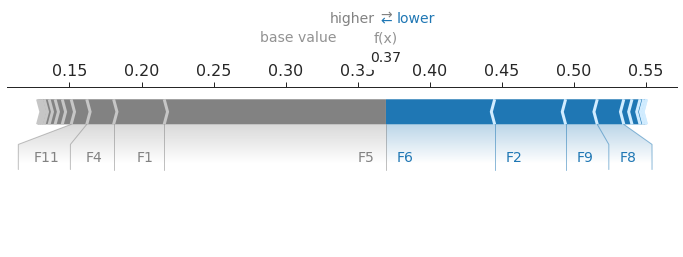

In [10]:
sns.set_style('white')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=1.8, rc=paper_rc)

fig = plt.gcf()
shap.force_plot(explainer.expected_value[target_class], agg_shap[instance], 
                feature_names=agg_features, matplotlib=True, show=False, figsize=(12,3))
plt.xlabel("")
plt.savefig("force_badcredit.pdf", dpi=300, bbox_inches='tight')
plt.show()

phi = 0.8


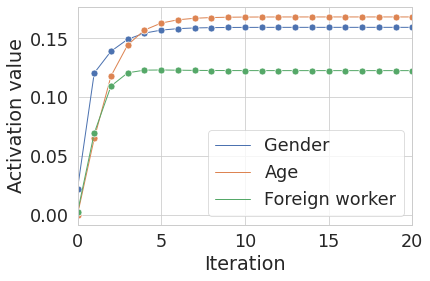

phi = 0.6


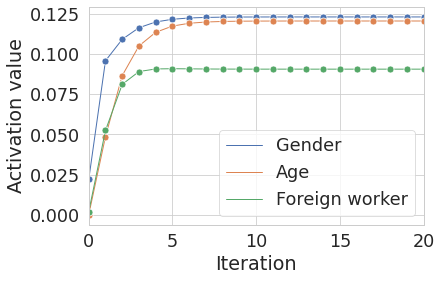

phi = 0.4


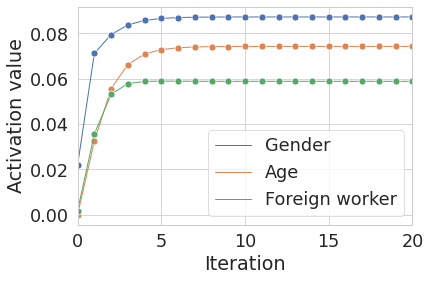

phi = 0.2


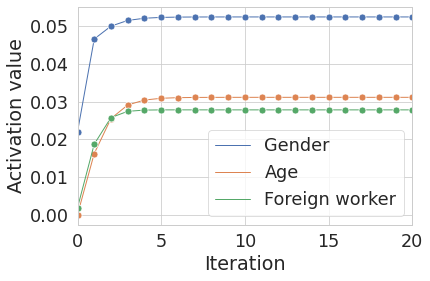

In [11]:
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=2, rc=paper_rc)

case = "bad_credit"
phi_values = [0.8, 0.6, 0.4, 0.2]

for i in range(len(phi_values)):
    
    df_plot = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(len(A)):
    
        state, _ = reasoning(W0, np.absolute(A), phi=phi_values[i], T=21)

        data_gender = state[0,:,8]
        data_age = state[0,:,12]
        data_foreign = state[0,:,19]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_gender))
        df1["value"] = data_gender.tolist()
        df1["feature"] = "Gender"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_age))
        df2["value"] = data_age.tolist()
        df2["feature"] = "Age"
        
        df3 = pd.DataFrame(columns=["feature","iteration","value"])
        df3["iteration"] = range(len(data_foreign))
        df3["value"] = data_foreign.tolist()
        df3["feature"] = "Foreign worker"
        
        df_plot = pd.concat([df_plot,df1,df2,df3], ignore_index=True)
    
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    sns.lineplot(data=df_plot, x="iteration", y="value", 
                       hue="feature", ax=ax, marker='o')
    ax.xaxis.get_major_locator().set_params(integer=True)
    
    plt.ylabel("Activation value")
    plt.xlabel("Iteration")
    
#     plt.ylim([0.0, 0.2])
    plt.legend(loc='best')
    
    plt.margins(x=0)
    plt.savefig(case + str(phi_values[i]) + ".pdf", bbox_inches='tight')
    print('phi =', phi_values[i])
    plt.show()

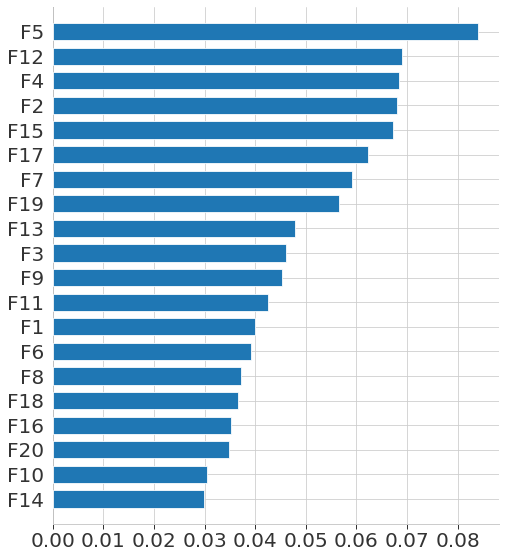

In [12]:
_, final = reasoning(W0, np.absolute(A), phi=0.8, T=21)
final /= sum(final[0])

fig = plt.gcf()
shap.summary_plot(final, plot_type='bar', feature_names=agg_features, show=False, color='tab:blue')

plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("activ_german_bad.pdf", bbox_inches='tight')
plt.show()

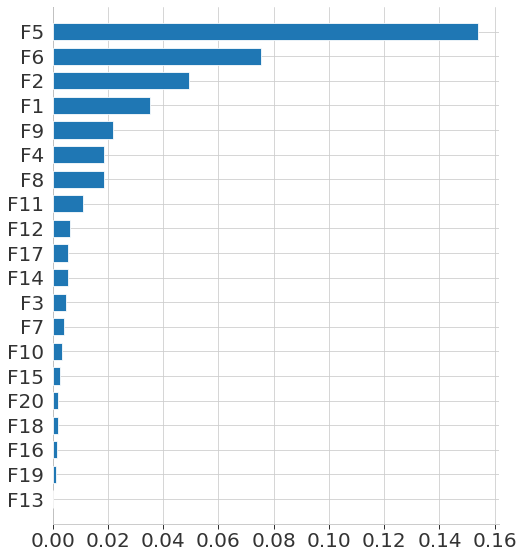

In [13]:
fig = plt.gcf()
shap.summary_plot(np.array([agg_shap[instance]]), plot_type='bar', feature_names=agg_features, show=False, color='tab:blue')

plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("shap_german_bad.pdf", bbox_inches='tight')
plt.show()

### Positive class

In [14]:
instance = 100
target_class = 1
agg_shap, agg_features = onehot_aggregator(shap_values[target_class], original_features, df.columns.astype("string"))

A = [agg_shap[instance]]
print(A)

[array([ 0.11333401,  0.01703205, -0.00353737, -0.01635204,  0.03854723,
        0.0362233 ,  0.00951706,  0.00173843,  0.0134895 ,  0.00056948,
        0.00840226,  0.00139784,  0.00828544,  0.01822798,  0.01319263,
        0.00616184,  0.00918591,  0.00189619,  0.01298152, -0.00129325])]


<Figure size 432x288 with 0 Axes>

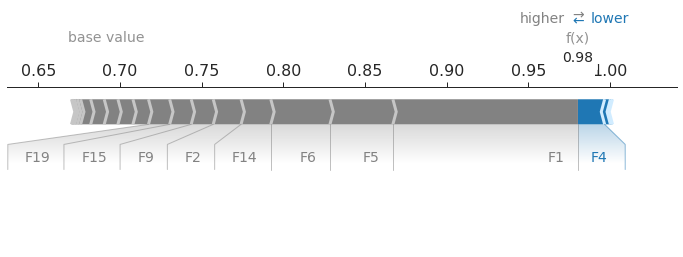

In [15]:
sns.set_style('white')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=1.8, rc=paper_rc)

fig = plt.gcf()
shap.force_plot(explainer.expected_value[target_class], agg_shap[instance], 
                feature_names=agg_features, matplotlib=True, show=False, figsize=(12,3))
plt.xlabel("")
plt.savefig("force_goodcredit.pdf", dpi=300, bbox_inches='tight')
plt.show()

phi = 0.8


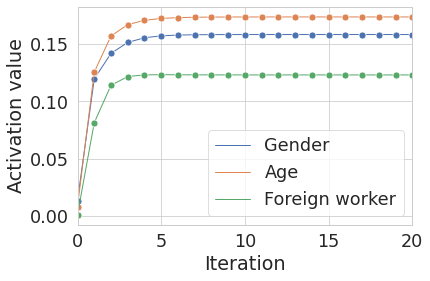

phi = 0.6


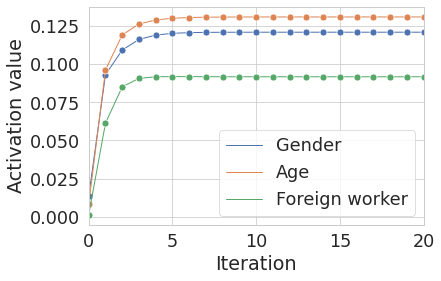

phi = 0.4


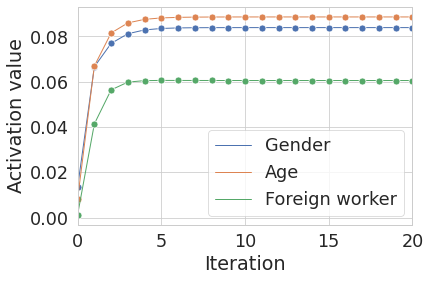

phi = 0.2


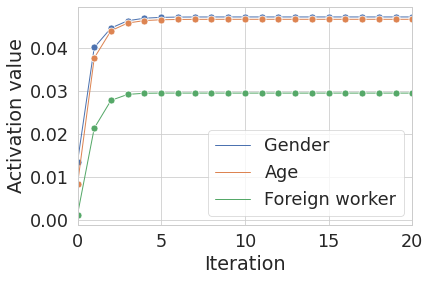

In [16]:
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context('paper', font_scale=2, rc=paper_rc)

case = "good_credit"
phi_values = [0.8, 0.6, 0.4, 0.2]

for i in range(len(phi_values)):
    
    df_plot = pd.DataFrame(columns=["feature","iteration","value"])
    
    for k in range(len(A)):
        
        state, _ = reasoning(W0, np.absolute(A), phi=phi_values[i], T=21)

        data_gender = state[0,:,8]
        data_age = state[0,:,12]
        data_foreign = state[0,:,19]
        
        df1 = pd.DataFrame(columns=["feature","iteration","value"])
        df1["iteration"] = range(len(data_gender))
        df1["value"] = data_gender.tolist()
        df1["feature"] = "Gender"
        
        df2 = pd.DataFrame(columns=["feature","iteration","value"])
        df2["iteration"] = range(len(data_age))
        df2["value"] = data_age.tolist()
        df2["feature"] = "Age"
        
        df3 = pd.DataFrame(columns=["feature","iteration","value"])
        df3["iteration"] = range(len(data_foreign))
        df3["value"] = data_foreign.tolist()
        df3["feature"] = "Foreign worker"
        
        df_plot = pd.concat([df_plot,df1,df2,df3], ignore_index=True)
    
    plt.figure(figsize=(6,4))
    ax = plt.gca()
    sns.lineplot(data=df_plot, x="iteration", y="value", 
                       hue="feature", ax=ax, marker='o')
    ax.xaxis.get_major_locator().set_params(integer=True)
    
    plt.ylabel("Activation value")
    plt.xlabel("Iteration")
    
#     plt.ylim([0.0, 0.2])
    plt.legend(loc='best')
    
    plt.margins(x=0)
    plt.savefig(case + str(phi_values[i]) + ".pdf", bbox_inches='tight')
    print('phi =', phi_values[i])
    plt.show()

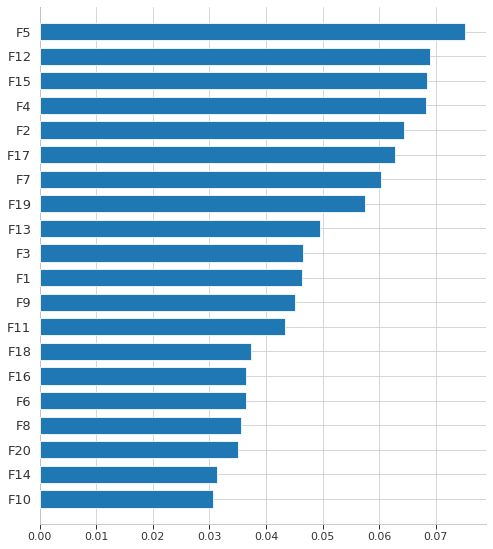

In [17]:
_, final = reasoning(W0, np.absolute(A), phi=0.8, T=21)
final /= sum(final[0])

fig = plt.gcf()
shap.summary_plot(final, plot_type='bar', feature_names=agg_features, show=False, color='tab:blue')
plt.xlabel("")
plt.savefig("activ_german_good.pdf", bbox_inches='tight')
plt.show()

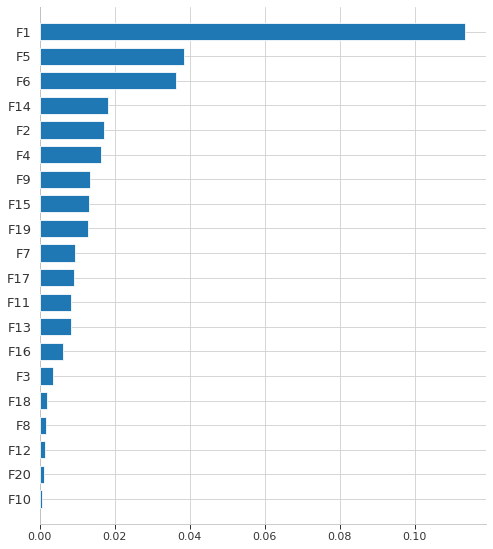

In [18]:
fig = plt.gcf()
shap.summary_plot(np.array([agg_shap[instance]]), plot_type='bar', feature_names=agg_features, show=False, color='tab:blue')
plt.xlabel("")
plt.savefig("shap_german_good.pdf", bbox_inches='tight')
plt.show()

### Global SHAP & mean correlation

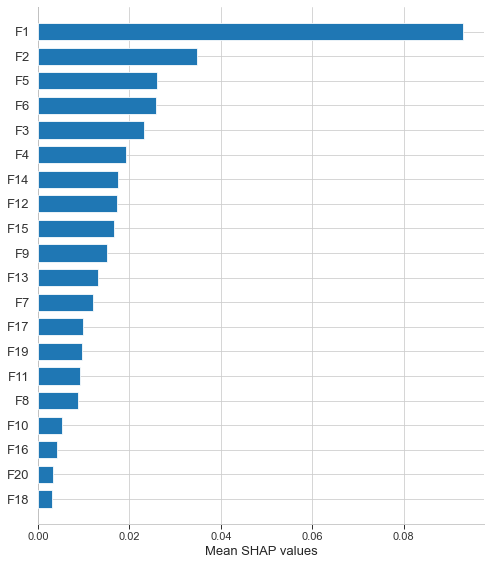

In [ ]:
fig = plt.gcf()
shap.summary_plot(agg_shap, plot_type='bar', feature_names=agg_features, show=False, color='tab:blue')
plt.xlabel("Mean SHAP values")
plt.savefig("shap_german.pdf", bbox_inches='tight')
plt.show()

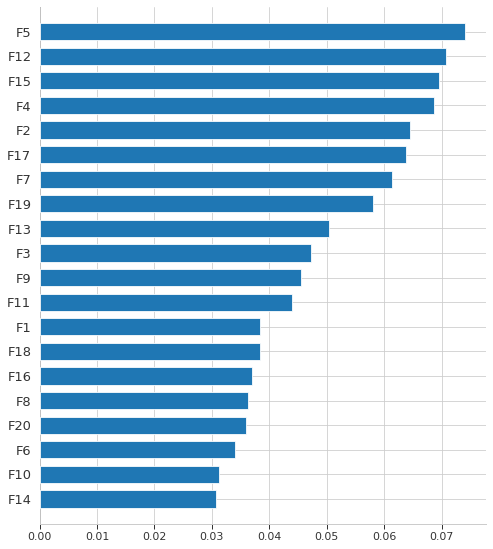

In [20]:
_, final = reasoning(W0, np.absolute(A), phi=1.0, T=21)
final /= sum(final[0])

fig = plt.gcf()
shap.summary_plot(final, plot_type='bar', feature_names=agg_features, show=False, color='tab:blue')
plt.xlabel("")
plt.savefig("activ_german_phi1.pdf", bbox_inches='tight')
plt.show()

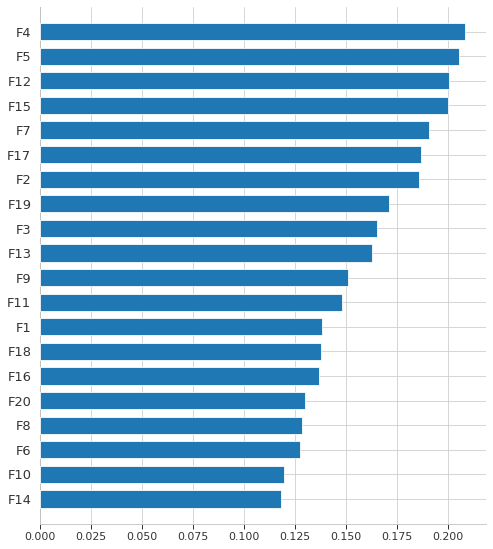

In [19]:
corr_mat = pd.DataFrame(W0, columns = agg_features)
mean_corr = corr_mat.mean(axis=0).sort_values(ascending=False)

fig = plt.gcf()

shap.summary_plot(mean_corr.values.reshape((1,-1)), plot_type='bar', 
                  feature_names=mean_corr.index, show=False, color='tab:blue')

plt.xlabel("")
plt.savefig("mean_corr_credit.pdf", bbox_inches='tight')
plt.show()